In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
#Define the data folder path
folder_path = './data/question_1c'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [3]:
# System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [4]:
#PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] # PV production per hour (kW)

In [5]:
#Load parameters
load_data = appliance_params['load'][0]
D_max = load_data['max_load_kWh_per_hour'] # Maximum power consumption (kW)
D_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio'] 
D_ref = [D_max * ratio for ratio in D_ref_ratio]  # reference load profile

In [6]:
## Battery parameters
Battery_data = appliance_params['storage'][0]
Battery_preferences = usage_preference[0]['storage_preferences'][0]
Batt_cap = Battery_data['storage_capacity_kWh']
Batt_max_ch_power = Battery_data['max_charging_power_ratio']*Batt_cap
Batt_max_dis_power = Battery_data['max_discharging_power_ratio']*Batt_cap
Batt_charging_eff = Battery_data['charging_efficiency']
Batt_discharging_eff = Battery_data['discharging_efficiency']
Batt_initial_soc = Battery_preferences['initial_soc_ratio']*Batt_cap
Batt_final_soc = Battery_preferences['final_soc_ratio']*Batt_cap
c_batt = 1200 # Battery cost coefficient (DKK/kWh)
N_batt = 10 *365 # battery lifetime (days)

In [7]:
print(f"Battery capacity: {Batt_cap} kWh")
print(f"Max charging power: {Batt_max_ch_power} kW")
print(f"Max discharging power: {Batt_max_dis_power} kW")

Battery capacity: 6.0 kWh
Max charging power: 0.8999999999999999 kW
Max discharging power: 1.7999999999999998 kW


In [8]:
# Temporal parameters
T = len(electricity_prices)  # 24 hours
Times = range(T) 
# discomfort parameter
alpha = 0.5

In [9]:
model = gp.Model("Energy_Optimization")

# Decision variable for battery sizing
gamma_batt = model.addVar(lb=0, name="gamma_batt")  # battery linear scaling factor

# Decision variables with FIXED upper bounds (not battery-related)
D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")  # Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  #Energy curtailed from PV (kW)
P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")  # Grid import (kW)
P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")  #Grid export (kW)
L_t = model.addVars(Times, lb=0, name="L_t")  # Discomfort (kW)

# Battery variables - NO upper bounds here, controlled by gamma_batt constraints
P_batt_ch = model.addVars(Times, lb=0, name="P_batt_ch")  #Battery charging power (kW)
P_batt_dis = model.addVars(Times, lb=0, name="P_batt_dis")  # Battery discharging power (kW)
SOC = model.addVars(Times, lb=0, name="SOC")  # State of Charge (kWh)


Set parameter Username
Set parameter LicenseID to value 2617496
Academic license - for non-commercial use only - expires 2026-02-03


In [10]:
#Objective function
# Minimize: Import Cost - Export Revenue + Discomfort Penalty
# Import Cost = P_imp * (tau_imp + price)
# Export Revenue = P_exp * (price - tau_exp)
#Discomfort Penalty = alpha * sum(L_t)
# Battery cost = c_batt * (gamma_batt * Batt_cap) / N_batt
model.setObjective(
    gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                P_exp_t[t] * (electricity_prices[t] - tau_exp) + alpha * L_t[t] for t in Times) +
                c_batt * (gamma_batt * Batt_cap) / N_batt,
    GRB.MINIMIZE)

In [11]:
#add constraints

# Curtailment constraint - cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

#discomfort constraints: L_t >= |D_t - D_ref[t]|
discomfort_constraint_1 = [
	model.addLConstr(L_t[t] >= D_t[t] - D_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(L_t[t] >= -(D_t[t] - D_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

# power balance constraint
power_balance_constraint = [
	model.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]

#Battery sizing constraints: Scale battery power and capacity with gamma_batt
battery_charge_limit = [
	model.addLConstr(P_batt_ch[t] <= Batt_max_ch_power * gamma_batt, name=f"batt_ch_limit_{t}")
	for t in Times
]

battery_discharge_limit = [
	model.addLConstr(P_batt_dis[t] <= Batt_max_dis_power * gamma_batt, name=f"batt_dis_limit_{t}")
	for t in Times
]

battery_soc_limit = [
	model.addLConstr(SOC[t] <= Batt_cap * gamma_batt, name=f"soc_limit_{t}")
	for t in Times
]

# Initial SOC constraint (scaled by gamma)
SOC_0 = [
    model.addConstr(SOC[0] == Batt_initial_soc * gamma_batt + P_batt_ch[0]*Batt_charging_eff - P_batt_dis[0]/Batt_discharging_eff, name="SOC_0")
]

#SOC dynamics constraint
SOC_dynamics = [
    model.addLConstr(SOC[t] == (SOC[t-1] + P_batt_ch[t]*Batt_charging_eff - P_batt_dis[t]/Batt_discharging_eff), name=f"SOC_dynamics_{t}")
    for t in Times if t > 0
]

# final SOC constraint (scaled by gamma)
SOC_end = [
    model.addLConstr(SOC[T-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
]

# Daily energy constraint: Total load must equal sum of reference load
daily_energy_constraint = model.addLConstr(
    gp.quicksum(D_t[t] for t in Times) == sum(D_ref), 
    name="daily_energy_constraint"
)


In [12]:
##solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 194 rows, 193 columns and 530 nonzeros
Model fingerprint: 0xbac64d1e
Coefficient statistics:
  Matrix range     [9e-01, 6e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
Presolve removed 25 rows and 10 columns
Presolve time: 0.01s
Presolved: 169 rows, 183 columns, 497 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.1030000e+04   3.582314e+03   0.000000e+00      0s
     154    2.8977926e+01   0.000000e+00   0.000000e+00      0s

Solved in 154 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.897792602e+01


In [13]:
# Print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("\n" + "="*70)
    print("OPTIMAL BATTERY SIZING")
    print("="*70)
    print(f"Scaling factor (gamma): {gamma_batt.X:.4f}")
    print(f"Optimal battery capacity: {gamma_batt.X * Batt_cap:.2f} kWh (base: {Batt_cap:.2f} kWh)")
    print(f"Optimal max charging power: {gamma_batt.X * Batt_max_ch_power:.2f} kW (base: {Batt_max_ch_power:.2f} kW)")
    print(f"Optimal max discharging power: {gamma_batt.X * Batt_max_dis_power:.2f} kW (base: {Batt_max_dis_power:.2f} kW)")
    print(f"Daily battery cost: {c_batt * (gamma_batt.X * Batt_cap) / N_batt:.4f} DKK")
    print("="*70)
    
    print("\nHour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]")
    for t in Times:
        print(f"{t:4d} | {D_t[t].X:9.2f} | {C_t[t].X:15.2f} | {P_imp_t[t].X:15.2f} | {P_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f} | {SOC[t].X:18.2f} | {P_batt_ch[t].X:18.2f} | {P_batt_dis[t].X:20.2f}")



Optimal solution found:
Total cost: 28.98 DKK

OPTIMAL BATTERY SIZING
Scaling factor (gamma): 1.0405
Optimal battery capacity: 6.24 kWh (base: 6.00 kWh)
Optimal max charging power: 0.94 kW (base: 0.90 kW)
Optimal max discharging power: 1.87 kW (base: 1.80 kW)
Daily battery cost: 2.0525 DKK

Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh) | State of Charge (kWh) | Battery charging [kW] | Battery discharging [kW]
   0 |      0.17 |            0.00 |            0.17 |            0.00 |               0.00 |                      1.10 |               3.12 |               0.00 |                 0.00
   1 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.05 |               3.12 |               0.00 |                 0.00
   2 |      0.12 |            0.00 |            0.27 |            0.00 |               0.00 |                      1.00 |               3

# Question 2.b.iv - Battery Profitability Analysis

## Consumer Flexibility Analysis

We analyze how optimal battery sizing varies with consumer flexibility (α parameter).

**Three Consumer Types:**
- **Highly Flexible (α = 0.1):** Cost-sensitive, willing to shift consumption
- **Moderately Flexible (α = 0.5):** Balanced cost-comfort tradeoff
- **Inflexible (α = 2.0):** Comfort-prioritizing, rigid consumption patterns

**Hypothesis:** Inflexible consumers benefit more from battery storage as it provides the flexibility they cannot achieve through load shifting.

In [14]:
# Function to solve for optimal battery sizing with given alpha
def solve_battery_sizing(alpha_value, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                         D_max_val, D_ref_vals, Batt_cap_val, Batt_max_ch, Batt_max_dis,
                         Batt_eff_ch, Batt_eff_dis, Batt_init_soc, Batt_final_soc,
                         c_batt_val, N_batt_val, max_imp, max_exp):
    """
    Solve battery sizing optimization for given alpha (discomfort weight)
    
    Returns: dict with results
    """
    Times = range(len(elec_prices))
    
    # Create model
    m = gp.Model(f"Battery_Sizing_alpha_{alpha_value}")
    m.setParam('OutputFlag', 0)  # Suppress output
    
    #Decision variables
    gamma_batt = m.addVar(lb=0, name="gamma_batt")
    D_t = m.addVars(Times, lb=0, ub=D_max_val, name="D_t")
    C_t = m.addVars(Times, lb=0, name="C_t")
    P_imp_t = m.addVars(Times, lb=0, ub=max_imp, name="P_imp_t")
    P_exp_t = m.addVars(Times, lb=0, ub=max_exp, name="P_exp_t")
    L_t = m.addVars(Times, lb=0, name="L_t")
    P_batt_ch = m.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = m.addVars(Times, lb=0, name="P_batt_dis")
    SOC = m.addVars(Times, lb=0, name="SOC")
    
    # Objective function
    m.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    P_exp_t[t] * (elec_prices[t] - tau_exp_val) + 
                    alpha_value * L_t[t] for t in Times) +
                    c_batt_val * (gamma_batt * Batt_cap_val) / N_batt_val,
        GRB.MINIMIZE
    )
    
    # Constraints
    for t in Times:
        # Curtailment constraint
        m.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        
        #Discomfort constraints
        m.addLConstr(L_t[t] >= D_t[t] - D_ref_vals[t], name=f"discomfort_1_{t}")
        m.addLConstr(L_t[t] >= -(D_t[t] - D_ref_vals[t]), name=f"discomfort_2_{t}")
        
        # Power balance
        m.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                     D_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
        
        # Battery sizing constraints
        m.addLConstr(P_batt_ch[t] <= Batt_max_ch * gamma_batt, name=f"batt_ch_limit_{t}")
        m.addLConstr(P_batt_dis[t] <= Batt_max_dis * gamma_batt, name=f"batt_dis_limit_{t}")
        m.addLConstr(SOC[t] <= Batt_cap_val * gamma_batt, name=f"soc_limit_{t}")
    
    #Initial SOC
    m.addConstr(SOC[0] == Batt_init_soc * gamma_batt + 
                P_batt_ch[0] * Batt_eff_ch - P_batt_dis[0] / Batt_eff_dis, 
                name="SOC_0")
    
    # SOC dynamics
    for t in Times:
        if t > 0:
            m.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t] * Batt_eff_ch - 
                         P_batt_dis[t] / Batt_eff_dis, name=f"SOC_dynamics_{t}")
    
    #Final SOC
    m.addLConstr(SOC[len(Times)-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
    
    # Daily energy constraint
    m.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref_vals), 
                 name="daily_energy_constraint")
    
    # Solve
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        # Calculate cost components
        energy_cost = sum(P_imp_t[t].X * (tau_imp_val + elec_prices[t]) - 
                         P_exp_t[t].X * (elec_prices[t] - tau_exp_val) for t in Times)
        discomfort_cost = alpha_value * sum(L_t[t].X for t in Times)
        battery_cost = c_batt_val * (gamma_batt.X * Batt_cap_val) / N_batt_val
        
        return {
            'alpha': alpha_value,
            'gamma': gamma_batt.X,
            'optimal_capacity': gamma_batt.X * Batt_cap_val,
            'total_cost': m.objVal,
            'energy_cost': energy_cost,
            'discomfort_cost': discomfort_cost,
            'battery_cost': battery_cost,
            'total_grid_import': sum(P_imp_t[t].X for t in Times),
            'total_grid_export': sum(P_exp_t[t].X for t in Times),
            'total_discomfort': sum(L_t[t].X for t in Times),
            'status': 'OPTIMAL'
        }
    else:
        return {
            'alpha': alpha_value,
            'gamma': None,
            'status': f'FAILED: {m.status}'
        }

In [15]:
# Define three consumer types
alpha_values = [0.1, 0.5, 2.0]
consumer_types = ['Highly Flexible', 'Moderately Flexible', 'Inflexible']

# store results
results = []

print("="*80)
print("OPTIMAL BATTERY SIZING FOR DIFFERENT CONSUMER TYPES")
print("="*80)

for alpha_val, consumer_type in zip(alpha_values, consumer_types):
    print(f"\nSolving for {consumer_type} (α = {alpha_val})...")
    
    result = solve_battery_sizing(
        alpha_value=alpha_val,
        pv_prod=pv_prod_hourly,
        elec_prices=electricity_prices,
        tau_imp_val=tau_imp,
        tau_exp_val=tau_exp,
        D_max_val=D_max,
        D_ref_vals=D_ref,
        Batt_cap_val=Batt_cap,
        Batt_max_ch=Batt_max_ch_power,
        Batt_max_dis=Batt_max_dis_power,
        Batt_eff_ch=Batt_charging_eff,
        Batt_eff_dis=Batt_discharging_eff,
        Batt_init_soc=Batt_initial_soc,
        Batt_final_soc=Batt_final_soc,
        c_batt_val=c_batt,
        N_batt_val=N_batt,
        max_imp=max_import,
        max_exp=max_export
    )
    
    result['consumer_type'] = consumer_type
    results.append(result)
    
    if result['status'] == 'OPTIMAL':
        print(f"  ✓ Optimal gamma: {result['gamma']:.4f}")
        print(f"    Battery capacity: {result['optimal_capacity']:.2f} kWh")
        print(f"    Total cost: {result['total_cost']:.2f} DKK")

print("\n" + "="*80)
print("SUMMARY")
print("="*80)

OPTIMAL BATTERY SIZING FOR DIFFERENT CONSUMER TYPES

Solving for Highly Flexible (α = 0.1)...
  ✓ Optimal gamma: 0.0000
    Battery capacity: 0.00 kWh
    Total cost: 23.35 DKK

Solving for Moderately Flexible (α = 0.5)...
  ✓ Optimal gamma: 1.0405
    Battery capacity: 6.24 kWh
    Total cost: 28.98 DKK

Solving for Inflexible (α = 2.0)...
  ✓ Optimal gamma: 1.5667
    Battery capacity: 9.40 kWh
    Total cost: 29.25 DKK

SUMMARY


In [16]:
#Display results in a clean table
import pandas as pd

# Create DataFrame
df_results = pd.DataFrame(results)

# Display key metrics
print(f"\n{'Consumer Type':<25} | {'Alpha':>8} | {'Gamma':>8} | {'Battery (kWh)':>15} | {'Total Cost (DKK)':>18}")
print("-" * 90)

for _, row in df_results.iterrows():
    if row['status'] == 'OPTIMAL':
        print(f"{row['consumer_type']:<25} | {row['alpha']:>8.1f} | {row['gamma']:>8.4f} | {row['optimal_capacity']:>15.2f} | {row['total_cost']:>18.2f}")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n1. Optimal battery sizing:")
print(f"   - Highly Flexible:     {df_results.iloc[0]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[0]['gamma']:.4f})")
print(f"   - Moderately Flexible: {df_results.iloc[1]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[1]['gamma']:.4f})")
print(f"   - Inflexible:          {df_results.iloc[2]['optimal_capacity']:.2f} kWh (γ = {df_results.iloc[2]['gamma']:.4f})")

# Calculate relative sizing
gamma_flexible = df_results.iloc[0]['gamma']
gamma_inflexible = df_results.iloc[2]['gamma']
ratio = gamma_inflexible / gamma_flexible if gamma_flexible > 0.001 else float('inf')

print(f"\n2. Inflexible consumers need {ratio:.1f}x more battery capacity than flexible consumers")

print(f"\n3. Cost breakdown:")
for _, row in df_results.iterrows():
    if row['status'] == 'OPTIMAL':
        print(f"\n   {row['consumer_type']}:")
        print(f"     - Energy cost:     {row['energy_cost']:>10.2f} DKK")
        print(f"     - Discomfort cost: {row['discomfort_cost']:>10.2f} DKK")
        print(f"     - Battery cost:    {row['battery_cost']:>10.2f} DKK")
        print(f"     - TOTAL:           {row['total_cost']:>10.2f} DKK")


Consumer Type             |    Alpha |    Gamma |   Battery (kWh) |   Total Cost (DKK)
------------------------------------------------------------------------------------------
Highly Flexible           |      0.1 |   0.0000 |            0.00 |              23.35
Moderately Flexible       |      0.5 |   1.0405 |            6.24 |              28.98
Inflexible                |      2.0 |   1.5667 |            9.40 |              29.25

KEY INSIGHTS

1. Optimal battery sizing:
   - Highly Flexible:     0.00 kWh (γ = 0.0000)
   - Moderately Flexible: 6.24 kWh (γ = 1.0405)
   - Inflexible:          9.40 kWh (γ = 1.5667)

2. Inflexible consumers need infx more battery capacity than flexible consumers

3. Cost breakdown:

   Highly Flexible:
     - Energy cost:          21.28 DKK
     - Discomfort cost:       2.07 DKK
     - Battery cost:          0.00 DKK
     - TOTAL:                23.35 DKK

   Moderately Flexible:
     - Energy cost:          25.74 DKK
     - Discomfort cost:       1.

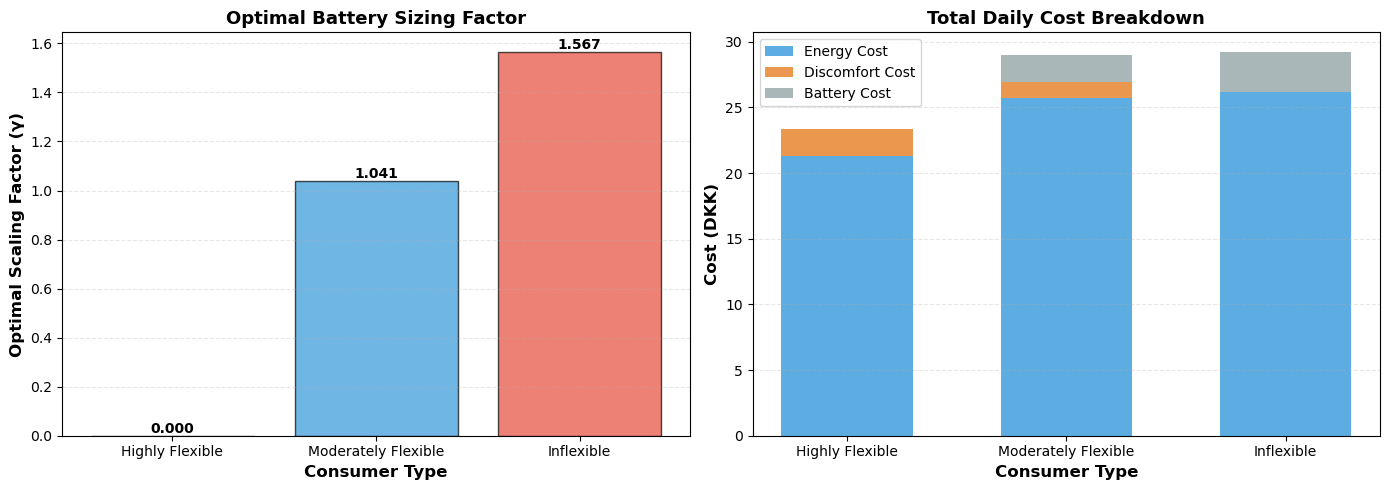

In [17]:
# Visualization: Optimal Battery Sizing by Consumer Type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Plot 1: Optimal Battery Capacity (gamma)
ax1 = axes[0]
colors = ['#2ecc71', '#3498db', '#e74c3c']  # Green, Blue, Red
bars1 = ax1.bar(consumer_types, [r['gamma'] for r in results], color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Optimal Scaling Factor (γ)', fontsize=12, fontweight='bold')
ax1.set_title('Optimal Battery Sizing Factor', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, result in zip(bars1, results):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{result["gamma"]:.3f}',
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Total Cost Breakdown
ax2 = axes[1]
energy_costs = [r['energy_cost'] for r in results]
discomfort_costs = [r['discomfort_cost'] for r in results]
battery_costs = [r['battery_cost'] for r in results]

x_pos = range(len(consumer_types))
width = 0.6

ax2.bar(x_pos, energy_costs, width, label='Energy Cost', color='#3498db', alpha=0.8)
ax2.bar(x_pos, discomfort_costs, width, bottom=energy_costs, 
        label='Discomfort Cost', color='#e67e22', alpha=0.8)
ax2.bar(x_pos, battery_costs, width, 
        bottom=[e+d for e,d in zip(energy_costs, discomfort_costs)],
        label='Battery Cost', color='#95a5a6', alpha=0.8)

ax2.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cost (DKK)', fontsize=12, fontweight='bold')
ax2.set_title('Total Daily Cost Breakdown', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(consumer_types)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

#save figure
import os
os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
plt.savefig('./Plots/Scenarios 2)/consumer_flexibility_analysis.png', dpi=300, bbox_inches='tight')

plt.show()



## Battery Cost Sensitivity Analysis

W

**Cost Range:** 600 - 1800 DKK/kWh



In [18]:
#battery cost sensitivity analysis
#test range: 600 to 1800 DKK/kWh in steps of 100

c_batt_values = np.arange(600, 1900, 100) 
alpha_test = [0.1, 0.5, 2.0]
consumer_labels = ['Highly Flexible (α=0.1)', 'Moderately Flexible (α=0.5)', 'Inflexible (α=2.0)']

#store results for each alpha and c_batt combination
sensitivity_results = {alpha: [] for alpha in alpha_test}

print("="*80)
print("BATTERY COST SENSITIVITY ANALYSIS")
print("="*80)
print(f"Testing battery costs from {c_batt_values[0]} to {c_batt_values[-1]} DKK/kWh")
print(f"Consumer types: α = {alpha_test}")
print("="*80)

for alpha_val in alpha_test:
    print(f"\nAnalyzing consumer type alpha = {alpha_val}...")
    
    for c_batt_test in c_batt_values:
        result = solve_battery_sizing(
            alpha_value=alpha_val,
            pv_prod=pv_prod_hourly,
            elec_prices=electricity_prices,
            tau_imp_val=tau_imp,
            tau_exp_val=tau_exp,
            D_max_val=D_max,
            D_ref_vals=D_ref,
            Batt_cap_val=Batt_cap,
            Batt_max_ch=Batt_max_ch_power,
            Batt_max_dis=Batt_max_dis_power,
            Batt_eff_ch=Batt_charging_eff,
            Batt_eff_dis=Batt_discharging_eff,
            Batt_init_soc=Batt_initial_soc,
            Batt_final_soc=Batt_final_soc,
            c_batt_val=c_batt_test,
            N_batt_val=N_batt,
            max_imp=max_import,
            max_exp=max_export
        )
        
        if result['status'] == 'OPTIMAL':
            sensitivity_results[alpha_val].append({
                'c_batt': c_batt_test,
                'gamma': result['gamma'],
                'capacity': result['optimal_capacity'],
                'total_cost': result['total_cost']
            })
    
    #find breakeven point (where gamma ≈ 0)
    gammas = [r['gamma'] for r in sensitivity_results[alpha_val]]
    c_batts = [r['c_batt'] for r in sensitivity_results[alpha_val]]
    
    #breakeven when gamma < 0.01
    breakeven_idx = next((i for i, g in enumerate(gammas) if g < 0.01), None)
    if breakeven_idx:
        print(f"  Breakeven at c_batt approximately {c_batts[breakeven_idx]} DKK/kWh (gamma < 0.01)")
    else:
        print(f"  Battery remains profitable across entire range")
    
    print(f"  gamma at 600 DKK/kWh: {gammas[0]:.4f}")
    print(f"  gamma at 1200 DKK/kWh: {gammas[6]:.4f}")  #index 6 = 1200
    print(f"  gamma at 1800 DKK/kWh: {gammas[-1]:.4f}")



BATTERY COST SENSITIVITY ANALYSIS
Testing battery costs from 600 to 1800 DKK/kWh
Consumer types: α = [0.1, 0.5, 2.0]

Analyzing consumer type alpha = 0.1...
  Battery remains profitable across entire range
  gamma at 600 DKK/kWh: 0.0000
  gamma at 1200 DKK/kWh: 0.0000
  gamma at 1800 DKK/kWh: 0.0000

Analyzing consumer type alpha = 0.5...
  Breakeven at c_batt approximately 1700 DKK/kWh (gamma < 0.01)
  gamma at 600 DKK/kWh: 1.8333
  gamma at 1200 DKK/kWh: 1.0405
  gamma at 1800 DKK/kWh: 0.0000

Analyzing consumer type alpha = 2.0...
  Battery remains profitable across entire range
  gamma at 600 DKK/kWh: 1.8333
  gamma at 1200 DKK/kWh: 1.5667
  gamma at 1800 DKK/kWh: 1.3867


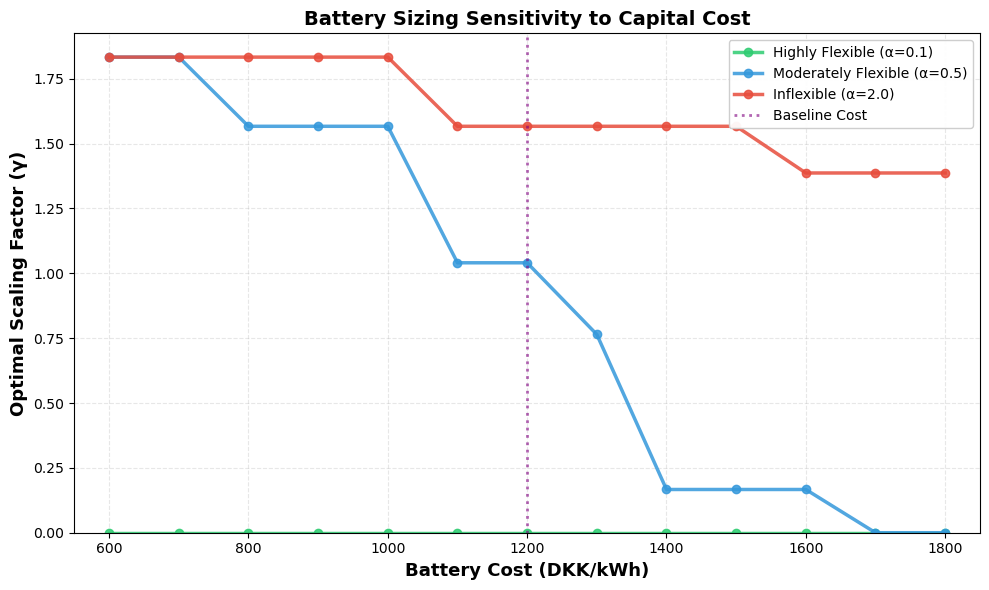

In [19]:
#visualization - battery cost sensitivity
fig, ax = plt.subplots(figsize=(10, 6))

#define colors for each consumer type
colors_sensitivity = ['#2ecc71', '#3498db', '#e74c3c']  #green, blue, red

#plot optimal gamma vs. battery cost
for idx, (alpha_val, label) in enumerate(zip(alpha_test, consumer_labels)):
    c_batts = [r['c_batt'] for r in sensitivity_results[alpha_val]]
    gammas = [r['gamma'] for r in sensitivity_results[alpha_val]]
    
    ax.plot(c_batts, gammas, marker='o', linewidth=2.5, markersize=6, 
            color=colors_sensitivity[idx], label=label, alpha=0.85)

#add vertical line at baseline cost (1200 DKK/kWh)
ax.axvline(x=1200, color='purple', linestyle=':', linewidth=2, alpha=0.6, label='Baseline Cost')

ax.set_xlabel('Battery Cost (DKK/kWh)', fontsize=13, fontweight='bold')
ax.set_ylabel('Optimal Scaling Factor (γ)', fontsize=13, fontweight='bold')
ax.set_title('Battery Sizing Sensitivity to Capital Cost', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim([550, 1850])
ax.set_ylim(bottom=0)

plt.tight_layout()

#save figure
import os
os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
plt.savefig('./Plots/Scenarios 2)/battery_cost_sensitivity.png', dpi=300, bbox_inches='tight')

plt.show()


## Constraint Binding Analysis

Identify which constraints limit battery sizing for each consumer type: capacity (SOC), charging power, or discharging power.

In [20]:
#function to return detailed solution for constraint analysis
def solve_battery_sizing_detailed(alpha_value, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                                   D_max_val, D_ref_vals, Batt_cap_val, Batt_max_ch, Batt_max_dis,
                                   Batt_eff_ch, Batt_eff_dis, Batt_init_soc, Batt_final_soc,
                                   c_batt_val, N_batt_val, max_imp, max_exp):
    """
    Solve battery sizing optimization and return detailed solution including all decision variables
    """
    Times = range(len(elec_prices))
    
    #create model
    m = gp.Model(f"Battery_Sizing_Detailed_alpha_{alpha_value}")
    m.setParam('OutputFlag', 0)
    
    #decision variables
    gamma_batt = m.addVar(lb=0, name="gamma_batt")
    D_t = m.addVars(Times, lb=0, ub=D_max_val, name="D_t")
    C_t = m.addVars(Times, lb=0, name="C_t")
    P_imp_t = m.addVars(Times, lb=0, ub=max_imp, name="P_imp_t")
    P_exp_t = m.addVars(Times, lb=0, ub=max_exp, name="P_exp_t")
    L_t = m.addVars(Times, lb=0, name="L_t")
    P_batt_ch = m.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = m.addVars(Times, lb=0, name="P_batt_dis")
    SOC = m.addVars(Times, lb=0, name="SOC")
    
    #objective function
    m.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    P_exp_t[t] * (elec_prices[t] - tau_exp_val) + 
                    alpha_value * L_t[t] for t in Times) +
                    c_batt_val * (gamma_batt * Batt_cap_val) / N_batt_val,
        GRB.MINIMIZE
    )
    
    #constraints
    for t in Times:
        m.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        m.addLConstr(L_t[t] >= D_t[t] - D_ref_vals[t], name=f"discomfort_1_{t}")
        m.addLConstr(L_t[t] >= -(D_t[t] - D_ref_vals[t]), name=f"discomfort_2_{t}")
        m.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                     D_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
        m.addLConstr(P_batt_ch[t] <= Batt_max_ch * gamma_batt, name=f"batt_ch_limit_{t}")
        m.addLConstr(P_batt_dis[t] <= Batt_max_dis * gamma_batt, name=f"batt_dis_limit_{t}")
        m.addLConstr(SOC[t] <= Batt_cap_val * gamma_batt, name=f"soc_limit_{t}")
    
    m.addConstr(SOC[0] == Batt_init_soc * gamma_batt + 
                P_batt_ch[0] * Batt_eff_ch - P_batt_dis[0] / Batt_eff_dis, 
                name="SOC_0")
    
    for t in Times:
        if t > 0:
            m.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t] * Batt_eff_ch - 
                         P_batt_dis[t] / Batt_eff_dis, name=f"SOC_dynamics_{t}")
    
    m.addLConstr(SOC[len(Times)-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
    m.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref_vals), 
                 name="daily_energy_constraint")
    
    #solve
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        #extract all time series data
        gamma_opt = gamma_batt.X
        soc_vals = [SOC[t].X for t in Times]
        p_ch_vals = [P_batt_ch[t].X for t in Times]
        p_dis_vals = [P_batt_dis[t].X for t in Times]
        
        #calculate utilization ratios
        soc_limit = gamma_opt * Batt_cap_val
        ch_limit = gamma_opt * Batt_max_ch
        dis_limit = gamma_opt * Batt_max_dis
        
        soc_utilization = [soc / soc_limit if soc_limit > 0.001 else 0 for soc in soc_vals]
        ch_utilization = [p_ch / ch_limit if ch_limit > 0.001 else 0 for p_ch in p_ch_vals]
        dis_utilization = [p_dis / dis_limit if dis_limit > 0.001 else 0 for p_dis in p_dis_vals]
        
        return {
            'alpha': alpha_value,
            'gamma': gamma_opt,
            'status': 'OPTIMAL',
            'soc': soc_vals,
            'p_charge': p_ch_vals,
            'p_discharge': p_dis_vals,
            'soc_utilization': soc_utilization,
            'ch_utilization': ch_utilization,
            'dis_utilization': dis_utilization,
            'soc_limit': soc_limit,
            'ch_limit': ch_limit,
            'dis_limit': dis_limit
        }
    else:
        return {'alpha': alpha_value, 'status': f'FAILED: {m.status}'}

In [21]:
#solve for all three consumer types and analyze constraint binding
alpha_analyze = [0.1, 0.5, 2.0]
consumer_names = ['Highly Flexible', 'Moderately Flexible', 'Inflexible']

detailed_results = []

print("="*80)
print("CONSTRAINT BINDING ANALYSIS")
print("="*80)
print("Solving at baseline battery cost (1200 DKK/kWh)")
print("="*80)

for alpha_val, name in zip(alpha_analyze, consumer_names):
    print(f"\nSolving for {name} (alpha = {alpha_val})...")
    
    result = solve_battery_sizing_detailed(
        alpha_value=alpha_val,
        pv_prod=pv_prod_hourly,
        elec_prices=electricity_prices,
        tau_imp_val=tau_imp,
        tau_exp_val=tau_exp,
        D_max_val=D_max,
        D_ref_vals=D_ref,
        Batt_cap_val=Batt_cap,
        Batt_max_ch=Batt_max_ch_power,
        Batt_max_dis=Batt_max_dis_power,
        Batt_eff_ch=Batt_charging_eff,
        Batt_eff_dis=Batt_discharging_eff,
        Batt_init_soc=Batt_initial_soc,
        Batt_final_soc=Batt_final_soc,
        c_batt_val=1200,  # Baseline cost
        N_batt_val=N_batt,
        max_imp=max_import,
        max_exp=max_export
    )
    
    result['consumer_type'] = name
    detailed_results.append(result)
    
    if result['status'] == 'OPTIMAL':
        #count binding constraints (within 1% of limit = 99%+ utilization)
        binding_threshold = 0.99
        
        soc_binding_count = sum(1 for u in result['soc_utilization'] if u >= binding_threshold)
        ch_binding_count = sum(1 for u in result['ch_utilization'] if u >= binding_threshold)
        dis_binding_count = sum(1 for u in result['dis_utilization'] if u >= binding_threshold)
        
        #maximum utilization
        max_soc_util = max(result['soc_utilization'])
        max_ch_util = max(result['ch_utilization'])
        max_dis_util = max(result['dis_utilization'])
        
        print(f"  Optimal gamma: {result['gamma']:.4f}")
        print(f"  Binding constraints (>= 99% utilization):")
        print(f"    SOC limit:       {soc_binding_count:2d} hours (max: {max_soc_util*100:5.1f}%)")
        print(f"    Charge power:    {ch_binding_count:2d} hours (max: {max_ch_util*100:5.1f}%)")
        print(f"    Discharge power: {dis_binding_count:2d} hours (max: {max_dis_util*100:5.1f}%)")

print("\n" + "="*80)

CONSTRAINT BINDING ANALYSIS
Solving at baseline battery cost (1200 DKK/kWh)

Solving for Highly Flexible (alpha = 0.1)...
  Optimal gamma: 0.0000
  Binding constraints (>= 99% utilization):
    SOC limit:        0 hours (max:   0.0%)
    Charge power:     0 hours (max:   0.0%)
    Discharge power:  0 hours (max:   0.0%)

Solving for Moderately Flexible (alpha = 0.5)...
  Optimal gamma: 1.0405
  Binding constraints (>= 99% utilization):
    SOC limit:        3 hours (max: 100.0%)
    Charge power:     7 hours (max: 100.0%)
    Discharge power:  1 hours (max: 100.0%)

Solving for Inflexible (alpha = 2.0)...
  Optimal gamma: 1.5667
  Binding constraints (>= 99% utilization):
    SOC limit:        3 hours (max: 100.0%)
    Charge power:     6 hours (max: 100.0%)
    Discharge power:  0 hours (max:  88.9%)



In [22]:
#summary table of limiting factors
print("="*80)
print("LIMITING FACTOR IDENTIFICATION")
print("="*80)

binding_summary = []

for result in detailed_results:
    if result['status'] == 'OPTIMAL':
        binding_threshold = 0.99
        
        #count binding hours
        soc_binding = sum(1 for u in result['soc_utilization'] if u >= binding_threshold)
        ch_binding = sum(1 for u in result['ch_utilization'] if u >= binding_threshold)
        dis_binding = sum(1 for u in result['dis_utilization'] if u >= binding_threshold)
        
        #maximum utilization
        max_soc = max(result['soc_utilization'])
        max_ch = max(result['ch_utilization'])
        max_dis = max(result['dis_utilization'])
        
        #determine primary limiting factor
        max_util = max(max_soc, max_ch, max_dis)
        if max_util == max_soc:
            primary_limit = "SOC (Capacity)"
        elif max_util == max_ch:
            primary_limit = "Charging Power"
        else:
            primary_limit = "Discharging Power"
        
        binding_summary.append({
            'Consumer Type': result['consumer_type'],
            'Alpha': result['alpha'],
            'Gamma': result['gamma'],
            'Primary Limit': primary_limit,
            'Max SOC (%)': max_soc * 100,
            'Max Charge (%)': max_ch * 100,
            'Max Discharge (%)': max_dis * 100,
            'SOC Binding Hours': soc_binding,
            'Charge Binding Hours': ch_binding,
            'Discharge Binding Hours': dis_binding
        })


LIMITING FACTOR IDENTIFICATION


NameError: name 'df_binding' is not defined

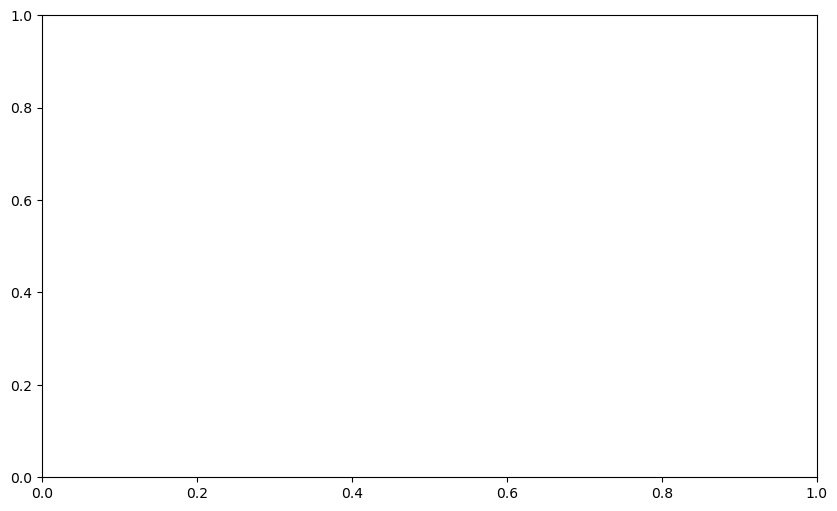

In [23]:
#bar chart comparison - maximum utilization across consumer types
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(consumer_names))
width = 0.25

max_soc_vals = [row['Max SOC (%)'] for _, row in df_binding.iterrows()]
max_ch_vals = [row['Max Charge (%)'] for _, row in df_binding.iterrows()]
max_dis_vals = [row['Max Discharge (%)'] for _, row in df_binding.iterrows()]

bars1 = ax.bar(x_pos - width, max_soc_vals, width, label='SOC (Capacity)', 
               color='#9b59b6', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x_pos, max_ch_vals, width, label='Charging Power', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x_pos + width, max_dis_vals, width, label='Discharging Power', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

#add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 5:  #only label significant values
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.0f}%',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Maximum Utilization (%)', fontsize=12, fontweight='bold')
ax.set_title('Constraint Utilization Comparison Across Consumer Types', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(consumer_names)
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

## Shadow Price Analysis

Shadow prices (dual variables) show the marginal value of relaxing each constraint. A higher shadow price indicates that relaxing that constraint would provide more cost reduction, revealing which constraints are truly limiting the battery sizing decision.

In [ ]:
#function to extract shadow prices from battery constraints
def solve_battery_sizing_with_duals(alpha_value, pv_prod, elec_prices, tau_imp_val, tau_exp_val, 
                                     D_max_val, D_ref_vals, Batt_cap_val, Batt_max_ch, Batt_max_dis,
                                     Batt_eff_ch, Batt_eff_dis, Batt_init_soc, Batt_final_soc,
                                     c_batt_val, N_batt_val, max_imp, max_exp):
    """
    Solve battery sizing optimization and return shadow prices (dual variables) for battery constraints
    """
    Times = range(len(elec_prices))
    
    #create model
    m = gp.Model(f"Battery_Sizing_Duals_alpha_{alpha_value}")
    m.setParam('OutputFlag', 0)
    
    #decision variables
    gamma_batt = m.addVar(lb=0, name="gamma_batt")
    D_t = m.addVars(Times, lb=0, ub=D_max_val, name="D_t")
    C_t = m.addVars(Times, lb=0, name="C_t")
    P_imp_t = m.addVars(Times, lb=0, ub=max_imp, name="P_imp_t")
    P_exp_t = m.addVars(Times, lb=0, ub=max_exp, name="P_exp_t")
    L_t = m.addVars(Times, lb=0, name="L_t")
    P_batt_ch = m.addVars(Times, lb=0, name="P_batt_ch")
    P_batt_dis = m.addVars(Times, lb=0, name="P_batt_dis")
    SOC = m.addVars(Times, lb=0, name="SOC")
    
    #objective function
    m.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp_val + elec_prices[t]) - 
                    P_exp_t[t] * (elec_prices[t] - tau_exp_val) + 
                    alpha_value * L_t[t] for t in Times) +
                    c_batt_val * (gamma_batt * Batt_cap_val) / N_batt_val,
        GRB.MINIMIZE
    )
    
    #constraints
    for t in Times:
        m.addLConstr(C_t[t] <= pv_prod[t], name=f"Curtailment_{t}")
        m.addLConstr(L_t[t] >= D_t[t] - D_ref_vals[t], name=f"discomfort_1_{t}")
        m.addLConstr(L_t[t] >= -(D_t[t] - D_ref_vals[t]), name=f"discomfort_2_{t}")
        m.addLConstr(P_imp_t[t] - P_exp_t[t] - P_batt_ch[t] + P_batt_dis[t] == 
                     D_t[t] - pv_prod[t] + C_t[t], name=f"power_balance_{t}")
    
    #store battery constraint references
    batt_ch_constrs = {}
    batt_dis_constrs = {}
    batt_soc_constrs = {}
    
    for t in Times:
        batt_ch_constrs[t] = m.addLConstr(P_batt_ch[t] <= Batt_max_ch * gamma_batt, name=f"batt_ch_limit_{t}")
        batt_dis_constrs[t] = m.addLConstr(P_batt_dis[t] <= Batt_max_dis * gamma_batt, name=f"batt_dis_limit_{t}")
        batt_soc_constrs[t] = m.addLConstr(SOC[t] <= Batt_cap_val * gamma_batt, name=f"soc_limit_{t}")
    
    m.addConstr(SOC[0] == Batt_init_soc * gamma_batt + 
                P_batt_ch[0] * Batt_eff_ch - P_batt_dis[0] / Batt_eff_dis, 
                name="SOC_0")
    
    for t in Times:
        if t > 0:
            m.addLConstr(SOC[t] == SOC[t-1] + P_batt_ch[t] * Batt_eff_ch - 
                         P_batt_dis[t] / Batt_eff_dis, name=f"SOC_dynamics_{t}")
    
    m.addLConstr(SOC[len(Times)-1] >= Batt_final_soc * gamma_batt, name="SOC_end")
    m.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref_vals), 
                 name="daily_energy_constraint")
    
    #solve
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        gamma_opt = gamma_batt.X
        
        #extract shadow prices (Pi = dual variable)
        soc_shadow = [abs(batt_soc_constrs[t].Pi) for t in Times]
        ch_shadow = [abs(batt_ch_constrs[t].Pi) for t in Times]
        dis_shadow = [abs(batt_dis_constrs[t].Pi) for t in Times]
        
        #calculate average shadow price (weighted by hours with non-zero dual)
        soc_nonzero = [sp for sp in soc_shadow if sp > 1e-6]
        ch_nonzero = [sp for sp in ch_shadow if sp > 1e-6]
        dis_nonzero = [sp for sp in dis_shadow if sp > 1e-6]
        
        avg_soc_shadow = sum(soc_nonzero) / len(soc_nonzero) if soc_nonzero else 0
        avg_ch_shadow = sum(ch_nonzero) / len(ch_nonzero) if ch_nonzero else 0
        avg_dis_shadow = sum(dis_nonzero) / len(dis_nonzero) if dis_nonzero else 0
        
        return {
            'alpha': alpha_value,
            'gamma': gamma_opt,
            'status': 'OPTIMAL',
            'soc_shadow': soc_shadow,
            'ch_shadow': ch_shadow,
            'dis_shadow': dis_shadow,
            'avg_soc_shadow': avg_soc_shadow,
            'avg_ch_shadow': avg_ch_shadow,
            'avg_dis_shadow': avg_dis_shadow,
            'max_soc_shadow': max(soc_shadow),
            'max_ch_shadow': max(ch_shadow),
            'max_dis_shadow': max(dis_shadow),
            'hours_soc_binding': len(soc_nonzero),
            'hours_ch_binding': len(ch_nonzero),
            'hours_dis_binding': len(dis_nonzero)
        }
    else:
        return {'alpha': alpha_value, 'status': f'FAILED: {m.status}'}

Shadow price extraction function created!


In [ ]:
#solve and extract shadow prices for consumer types with batteries
shadow_results = []
gamma_threshold = 0.01  #minimum gamma to analyze (no battery if below this)

print("Solving for shadow price analysis...")
print(f"Note: Only analyzing consumer types with gamma >= {gamma_threshold}")

for alpha_val, name in zip(alpha_analyze, consumer_names):
    result = solve_battery_sizing_with_duals(
        alpha_value=alpha_val,
        pv_prod=pv_prod_hourly,
        elec_prices=electricity_prices,
        tau_imp_val=tau_imp,
        tau_exp_val=tau_exp,
        D_max_val=D_max,
        D_ref_vals=D_ref,
        Batt_cap_val=Batt_cap,
        Batt_max_ch=Batt_max_ch_power,
        Batt_max_dis=Batt_max_dis_power,
        Batt_eff_ch=Batt_charging_eff,
        Batt_eff_dis=Batt_discharging_eff,
        Batt_init_soc=Batt_initial_soc,
        Batt_final_soc=Batt_final_soc,
        c_batt_val=1200,
        N_batt_val=N_batt,
        max_imp=max_import,
        max_exp=max_export
    )
    
    result['consumer_type'] = name
    
    #check if battery was installed
    if result['status'] == 'OPTIMAL' and result['gamma'] >= gamma_threshold:
        shadow_results.append(result)
        print(f"  {name}: gamma = {result['gamma']:.4f} - Shadow prices calculated")
    else:
        print(f"  {name}: gamma = {result['gamma']:.4f} - Skipped (no battery)")

#create dataframe for visualization (only consumers with batteries)
shadow_summary = []
for result in shadow_results:
    shadow_summary.append({
        'Consumer Type': result['consumer_type'],
        'Alpha': result['alpha'],
        'Gamma': result['gamma'],
        'Avg SOC Shadow (DKK)': result['avg_soc_shadow'],
        'Avg Charge Shadow (DKK)': result['avg_ch_shadow'],
        'Avg Discharge Shadow (DKK)': result['avg_dis_shadow']
    })

df_shadow = pd.DataFrame(shadow_summary)

Solving for shadow price analysis...
Note: Only analyzing consumer types with gamma >= 0.01
  Highly Flexible: gamma = 0.0000 - Skipped (no battery)
  Moderately Flexible: gamma = 1.0405 - Shadow prices calculated
  Inflexible: gamma = 1.5667 - Shadow prices calculated

Shadow price analysis complete! Analyzed 2 consumer type(s) with batteries.
  Highly Flexible: gamma = 0.0000 - Skipped (no battery)
  Moderately Flexible: gamma = 1.0405 - Shadow prices calculated
  Inflexible: gamma = 1.5667 - Shadow prices calculated

Shadow price analysis complete! Analyzed 2 consumer type(s) with batteries.


Figure saved to: ./Plots/Scenarios 2)/shadow_price_analysis.png


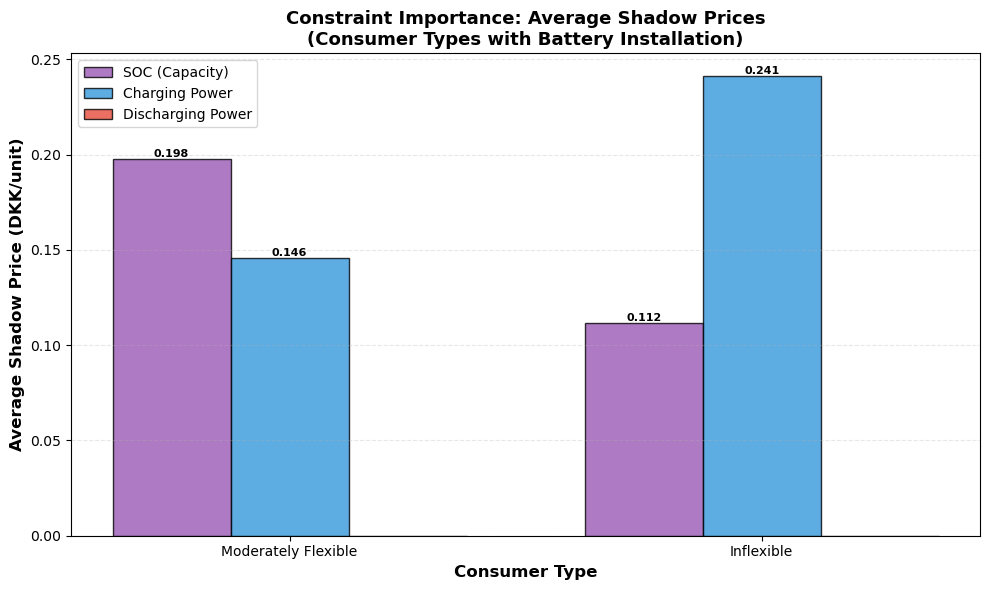

Average shadow price comparison complete!


In [ ]:
#visualization - average shadow prices by consumer type (only those with batteries)
if len(df_shadow) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    #get consumer names from dataframe (only those with batteries)
    consumer_names_with_battery = df_shadow['Consumer Type'].tolist()
    x_pos = np.arange(len(consumer_names_with_battery))
    width = 0.25
    
    avg_soc_shadow = [row['Avg SOC Shadow (DKK)'] for _, row in df_shadow.iterrows()]
    avg_ch_shadow = [row['Avg Charge Shadow (DKK)'] for _, row in df_shadow.iterrows()]
    avg_dis_shadow = [row['Avg Discharge Shadow (DKK)'] for _, row in df_shadow.iterrows()]
    
    bars1 = ax.bar(x_pos - width, avg_soc_shadow, width, label='SOC (Capacity)', 
                   color='#9b59b6', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x_pos, avg_ch_shadow, width, label='Charging Power', 
                   color='#3498db', alpha=0.8, edgecolor='black')
    bars3 = ax.bar(x_pos + width, avg_dis_shadow, width, label='Discharging Power', 
                   color='#e74c3c', alpha=0.8, edgecolor='black')
    
    #add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0.0001:  #only label non-zero values
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax.set_xlabel('Consumer Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Shadow Price (DKK/unit)', fontsize=12, fontweight='bold')
    ax.set_title('Constraint Importance: Average Shadow Prices\n(Consumer Types with Battery Installation)', 
                 fontsize=13, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(consumer_names_with_battery)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    #save figure
    import os
    os.makedirs('./Plots/Scenarios 2)', exist_ok=True)
    plt.savefig('./Plots/Scenarios 2)/shadow_price_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("No consumer types installed batteries (all gamma < 0.01)")